In [1]:
#  Data selection and preprocessing
# ------------------------------------------------------------------------

# 1. Install & import dependencies
!pip install ONE-api brainbox ibllib --quiet

import numpy as np
import pandas as pd
from one.api import ONE
from one.remote.aws import s3_download_file
from pathlib import Path
from scipy import sparse

# 2. ONE setup
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE()

# 3. Utility functions (adapted from tutorial)
def download_data(event: str):
    assert event in ('stimOn','firstMove','feedback')
    fname = f'data_{event}.zip'
    remote = f'sample_data/Neuromatch/{fname}'
    local_dir = Path(one.cache_dir) / 'Neuromatch'
    local_dir.mkdir(parents=True, exist_ok=True)
    target = Path(one.cache_dir) / 'Neuromatch' / fname
    s3_download_file(remote, target)
    import zipfile
    with zipfile.ZipFile(target, 'r') as z:
        z.extractall(local_dir)

def load_metadata(event: str):
    base = Path(one.cache_dir) / 'Neuromatch' / f'data_{event}'
    meta = {}
    meta['clusters'] = pd.read_parquet(base/'clusters.pqt')
    meta['trials']   = pd.read_parquet(base/'trials.pqt')
    meta['sessions'] = pd.read_parquet(base/'sessions.pqt')
    meta['times']    = np.load(base/'t.npy')
    meta['nbins']    = meta['times'].size
    meta['dt']       = np.median(np.diff(meta['times']))
    meta['data_dir'] = base
    return meta

def load_psth(pid: str, meta: dict):
    arr = sparse.load_npz(meta['data_dir']/f'{pid}.npz').toarray()
    return arr.reshape(arr.shape[0], -1, meta['nbins']) / meta['dt']

# 4. Download & load stimulus-aligned data
download_data('stimOn')
meta = load_metadata('stimOn')

# 5. Select trial subsets: 100% vs 0% contrast, by choice side
trials = meta['trials']
# compute signed contrast
trials['contrast'] = (trials['contrastLeft'].fillna(0) + trials['contrastRight'].fillna(0)) * 100

# high-contrast trials (100%) & zero-contrast (0%)
high = trials[trials['contrast'] == 100]
zero = trials[trials['contrast'] == 0]

# separate left/right
conds = {
    'sensory_left':  high[high['choice'] == -1],
    'sensory_right': high[high['choice'] ==  1],
    'memory_left':   zero[zero['choice'] == -1],
    'memory_right':  zero[zero['choice'] ==  1]
}

# 6. Regions of interest
regions = ['VISp','RSP','CA1','MOp']  # visual, retrosplenial, hippocampus, motor

# 7. Gather per-region average PSTHs, handling empty conditions
region_psth = {}
for reg in regions:
    # clusters in region
    clusts = meta['clusters']
    reg_clusts = clusts[clusts['acronym'] == reg]
    pids = reg_clusts['pid'].unique()
    region_psth[reg] = {}
    for cond_name, cond_trials in conds.items():
        psth_list = []
        for pid in pids:
            A = load_psth(pid, meta)  # shape: (n_trials, n_neurons, nbins)
            # find trial indices matching this session & condition
            eid = meta['sessions'].loc[meta['sessions']['pid'] == pid, 'eid'].iloc[0]
            idx = cond_trials[cond_trials['eid'] == eid]['psth_index'].values
            if idx.size > 0:
                # mean across selected trials and all neurons
                psth_list.append(A[idx, :, :].mean(axis=(0,1)))
        if psth_list:
            # stack only if there is data
            region_psth[reg][cond_name] = np.stack(psth_list).mean(axis=0)
        else:
            # assign NaNs if no data for this condition in this region
            region_psth[reg][cond_name] = np.full(meta['nbins'], np.nan)

# 8. (Optional) Z-score across all conditions per region
for reg in regions:
    data = np.vstack([region_psth[reg][c] for c in region_psth[reg]])
    mu, sigma = np.nanmean(data), np.nanstd(data)
    for c in region_psth[reg]:
        region_psth[reg][c] = (region_psth[reg][c] - mu) / sigma

# region_psth now holds z-scored average PSTHs (or NaNs) for each region & condition,
# robustly handling cases with no trials in a condition.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.3/996.3 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.4/414.4 kB 24.0 MB/s eta

(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/Neuromatch/data_stimOn.zip: 100%|██████████| 810M/810M [00:04<00:00, 196MB/s]
/tmp/ipython-input-1-1072265973.py:99: RuntimeWarning: Mean of empty slice
  mu, sigma = np.nanmean(data), np.nanstd(data)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


region_psth[region][condition] = numpy array of PSTH values

Where:

Regions: 'VISp' (Visual cortex), 'RSP' (Retrosplenial), 'CA1' (Hippocampus), 'MOp' (Motor cortex)

Conditions: 'sensory_left', 'sensory_right', 'memory_left', 'memory_right'

# Get all available regions
regions = list(region_psth.keys())
print(regions)  # ['VISp', 'RSP', 'CA1', 'MOp']


# # Get all conditions for visual cortex
conditions = list(region_psth['VISp'].keys())
print(conditions)  # ['sensory_left', 'sensory_right', 'memory_left', 'memory_right']

#  Get PSTH for visual cortex, sensory left trials
psth_data = region_psth['VISp']['sensory_left']
print(f'Shape: {psth_data.shape}, Type: {type(psth_data)}')

# # Get time points (from meta data)
time_points = meta['times']
print(f'Time range: {time_points[0]:.2f} to {time_points[-1]:.2f} seconds')
print(f'Number of time bins: {len(time_points)}')

# Get PSTH for visual cortex, sensory left trials
psth_data = region_psth['VISp']['sensory_left']
print(f'Shape: {psth_data.shape}, Type: {type(psth_data)}')




## Plot some basic plots
- sanity check if dict is loaded correctly

/tmp/ipython-input-2-3662630604.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


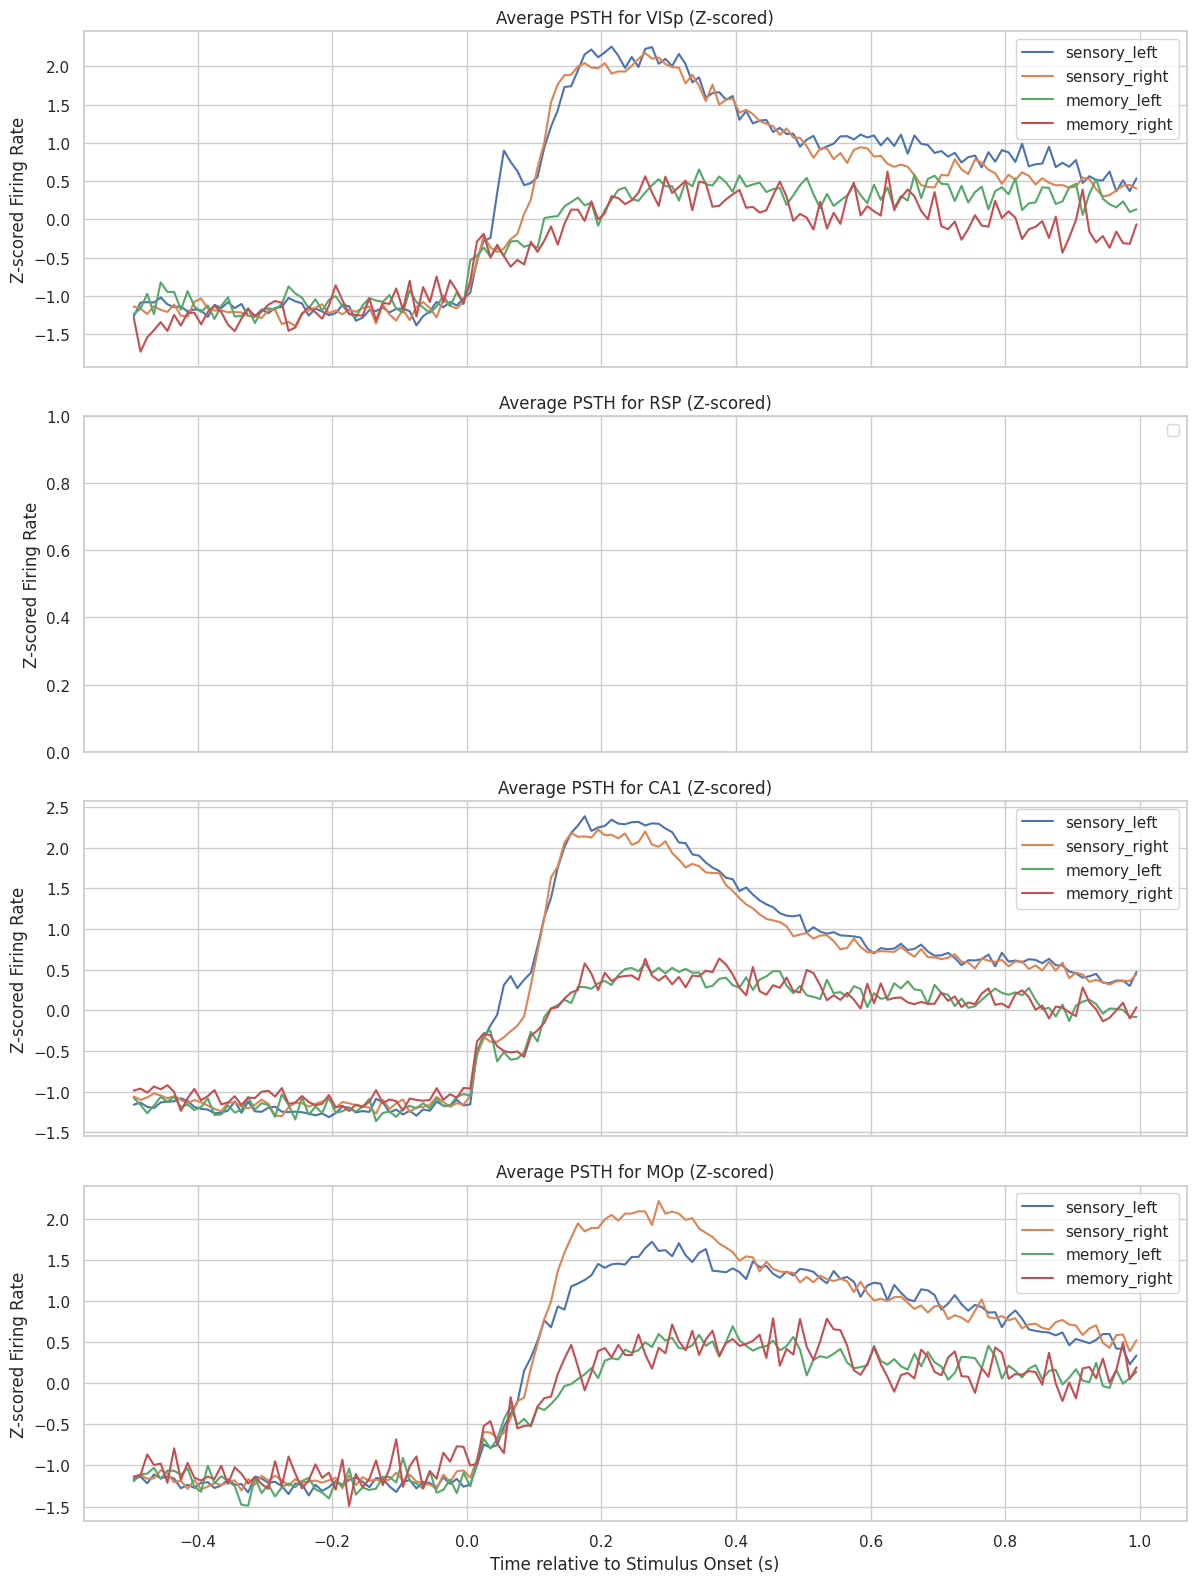

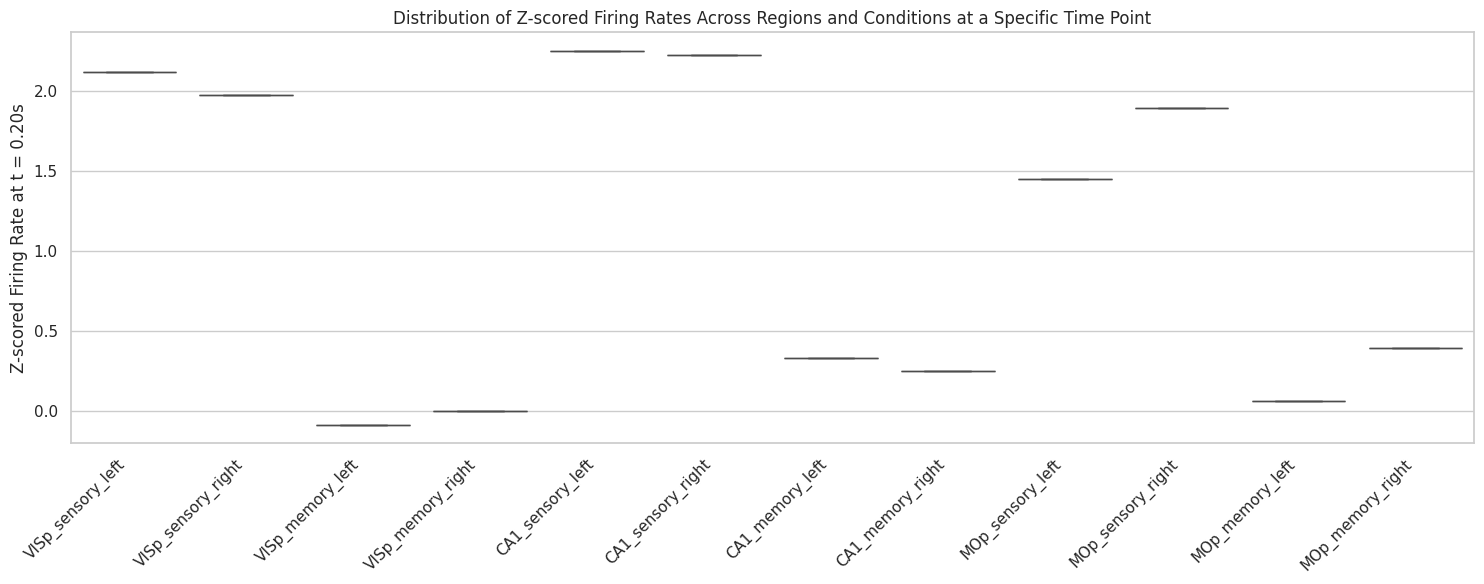

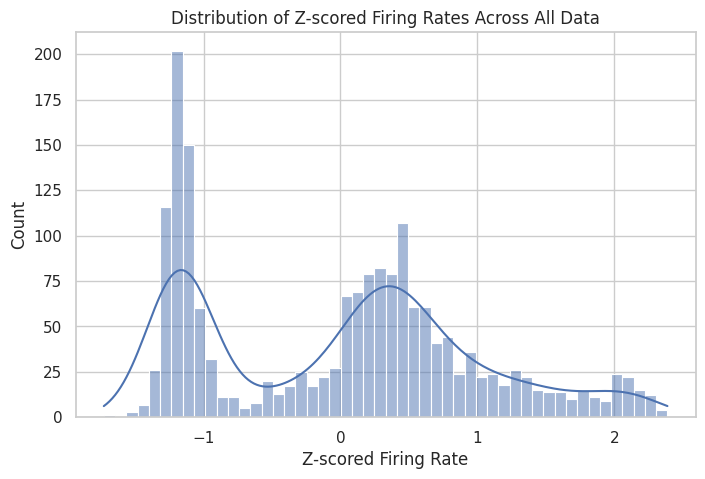

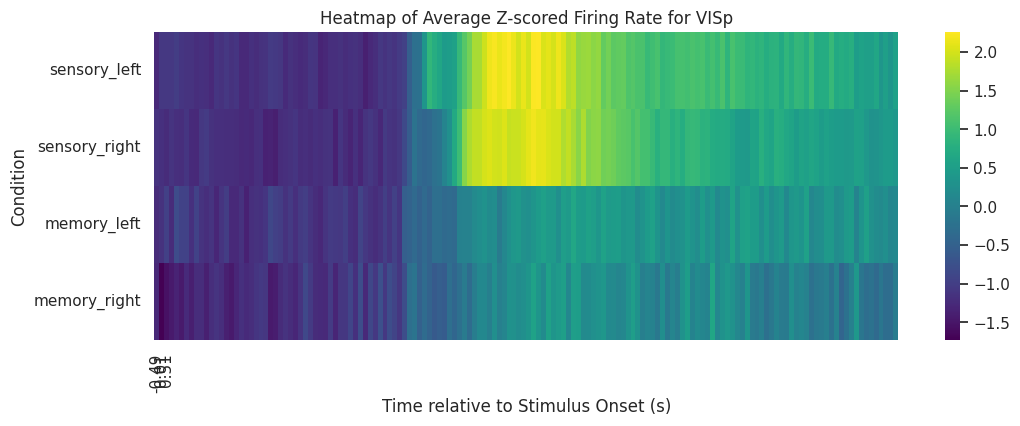

In [2]:
# prompt: plot some basic plots to analyse the data. How does the data look  reg_psth ? Plot firing activity vs time and some other basic plots to perform and exploratory data analysis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for plots
sns.set_theme(style="whitegrid")

# Plotting firing activity vs time for each region and condition
fig, axes = plt.subplots(len(regions), 1, figsize=(12, 4 * len(regions)), sharex=True)
axes = axes.flatten() # Ensure axes is an iterable

for i, reg in enumerate(regions):
    ax = axes[i]
    for cond_name, psth_data in region_psth[reg].items():
        # Only plot if there is data (not all NaNs)
        if not np.all(np.isnan(psth_data)):
            ax.plot(meta['times'], psth_data, label=cond_name)

    ax.set_title(f'Average PSTH for {reg} (Z-scored)')
    ax.set_ylabel('Z-scored Firing Rate')
    ax.legend(loc='upper right')

axes[-1].set_xlabel('Time relative to Stimulus Onset (s)')
plt.tight_layout()
plt.show()

# Other basic plots for exploratory data analysis

# Example: Boxplot of Z-scored firing rates at a specific time point (e.g., peak activity)
# This requires identifying a representative time point, which might vary by region/condition.
# As a simple example, let's pick a time point around 0.2 seconds after stimulus onset.
time_point_index = np.argmin(np.abs(meta['times'] - 0.2))

data_for_boxplot = []
labels_for_boxplot = []

for reg in regions:
    for cond_name, psth_data in region_psth[reg].items():
        # Only include if there is data
        if not np.all(np.isnan(psth_data)):
            data_for_boxplot.append(psth_data[time_point_index])
            labels_for_boxplot.append(f'{reg}_{cond_name}')

if data_for_boxplot:
    plt.figure(figsize=(15, 6))
    sns.boxplot(x=labels_for_boxplot, y=data_for_boxplot)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Z-scored Firing Rate at t = {meta["times"][time_point_index]:.2f}s')
    plt.title('Distribution of Z-scored Firing Rates Across Regions and Conditions at a Specific Time Point')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for boxplot at the selected time point.")


# Example: Distribution of Z-scored firing rates across all regions and conditions
all_z_scores = np.concatenate([
    region_psth[reg][c][~np.isnan(region_psth[reg][c])]
    for reg in regions for c in region_psth[reg]
])

if all_z_scores.size > 0:
    plt.figure(figsize=(8, 5))
    sns.histplot(all_z_scores, bins=50, kde=True)
    plt.xlabel('Z-scored Firing Rate')
    plt.ylabel('Count')
    plt.title('Distribution of Z-scored Firing Rates Across All Data')
    plt.show()
else:
     print("No data available for overall distribution plot.")

# Example: Heatmap of average firing rates across time for a specific region
# Let's pick the first region in the list
if regions:
    selected_region = regions[0]
    heatmap_data = []
    heatmap_labels = []
    for cond_name, psth_data in region_psth[selected_region].items():
        if not np.all(np.isnan(psth_data)):
            heatmap_data.append(psth_data)
            heatmap_labels.append(cond_name)

    if heatmap_data:
        plt.figure(figsize=(12, len(heatmap_data)))
        sns.heatmap(np.vstack(heatmap_data), cmap='viridis', yticklabels=heatmap_labels, xticklabels=[f'{t:.2f}' for t in meta['times'][::50]]) # show every 50th time label for readability
        plt.xlabel('Time relative to Stimulus Onset (s)')
        plt.ylabel('Condition')
        plt.title(f'Heatmap of Average Z-scored Firing Rate for {selected_region}')
        plt.yticks(rotation=0)
        plt.show()
    else:
        print(f"No data available for heatmap for region {selected_region}.")
else:
    print("No regions defined to plot heatmap.")


Plotting PSTH for sample PID: 56f2a378-78d2-4132-b3c8-8c1ba82be598, sample Cluster ID: 2


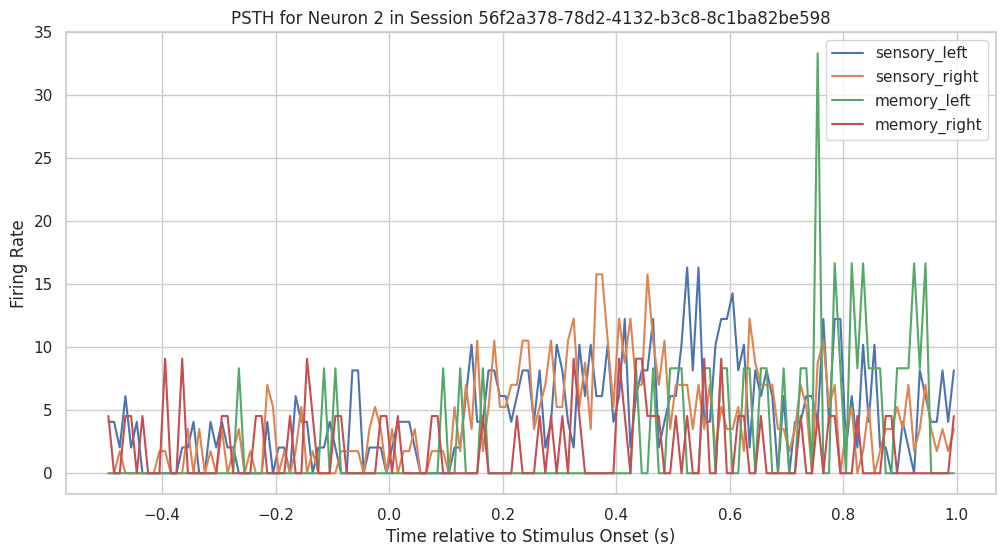

In [3]:
# prompt: plot the psth for some individual neurons so I can see the spikes

import matplotlib.pyplot as plt
import numpy as np
# Function to plot PSTH for a single neuron
def plot_neuron_psth(pid, cluster_id, meta, conds, times, title=None):
    """
    Plots the PSTH for a specific neuron (cluster_id) from a given session (pid).

    Args:
        pid (str): The session ID (probe ID).
        cluster_id (int): The ID of the neuron (cluster).
        meta (dict): Metadata dictionary containing times, nbins, data_dir.
        conds (dict): Dictionary of trial conditions and their corresponding trial indices.
        times (np.ndarray): Time bins for the PSTH.
        title (str, optional): Custom title for the plot. Defaults to None.
    """
    A = load_psth(pid, meta)  # shape: (n_trials, n_neurons, nbins)

    plt.figure(figsize=(12, 6))
    for cond_name, cond_trials in conds.items():
        # find trial indices matching this session & condition
        eid = meta['sessions'].loc[meta['sessions']['pid'] == pid, 'eid'].iloc[0]
        idx = cond_trials[cond_trials['eid'] == eid]['psth_index'].values

        if idx.size > 0:
            # Check if the cluster_id is valid for this PID
            clusts = meta['clusters']
            valid_clusters_for_pid = clusts[clusts['pid'] == pid]['cluster_id'].values
            if cluster_id in valid_clusters_for_pid:
                # Select the specific neuron's data and average across selected trials
                # Find the index of the cluster_id within the data array for this PID
                cluster_idx_in_array = np.where(valid_clusters_for_pid == cluster_id)[0]
                if cluster_idx_in_array.size > 0:
                     neuron_psth = A[idx, cluster_idx_in_array[0], :].mean(axis=0)
                     plt.plot(times, neuron_psth, label=cond_name)
                else:
                     print(f"Cluster ID {cluster_id} not found in the data array for PID {pid}.")

            else:
                print(f"Cluster ID {cluster_id} does not belong to PID {pid}.")


    plt.xlabel('Time relative to Stimulus Onset (s)')
    plt.ylabel('Firing Rate')
    plt.title(title if title else f'PSTH for Neuron {cluster_id} in Session {pid}')
    plt.legend(loc='upper right')
    plt.show()


# Example Usage: Plot PSTH for a specific neuron
# You need to select a PID and a cluster_id that exists within that PID.
# You can inspect meta['clusters'] to find valid combinations.

# Find a sample PID and cluster_id
sample_pid = meta['clusters']['pid'].iloc[0]
sample_cluster_id = meta['clusters'][meta['clusters']['pid'] == sample_pid]['cluster_id'].iloc[0]

print(f"Plotting PSTH for sample PID: {sample_pid}, sample Cluster ID: {sample_cluster_id}")

plot_neuron_psth(sample_pid, sample_cluster_id, meta, conds, meta['times'])


# You can plot for other neurons by changing sample_pid and sample_cluster_id
# For example, to plot for the 5th neuron in the list of clusters:
# sample_pid_2 = meta['clusters']['pid'].iloc[4]
# sample_cluster_id_2 = meta['clusters'][meta['clusters']['pid'] == sample_pid_2]['cluster_id'].iloc[0]
# print(f"Plotting PSTH for sample PID: {sample_pid_2}, sample Cluster ID: {sample_cluster_id_2}")
# plot_neuron_psth(sample_pid_2, sample_cluster_id_2, meta, conds, meta['times'])

# If you want to plot for specific cluster IDs and PIDs you know exist:
# plot_neuron_psth('some_pid', 123, meta, conds, meta['times']) # Replace with actual PID and cluster ID

## Prepare data matrix and run pca

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Example: region_psth = {'VISp': {'sensory_left': np.array([...]), ...}, ...}

X = []
labels = []
region_labels = []
condition_labels = []

for region, conds in region_psth.items():
    for cond_name, psth in conds.items():
        if not np.isnan(psth).all():  # skip if all NaNs
            X.append(psth)
            region_labels.append(region)
            condition_labels.append(cond_name)
            if 'sensory' in cond_name:
                labels.append('sensory')
            else:
                labels.append('memory')
X = np.array(X)


In [10]:
print(X.shape)
print(np.max(X), np.min(X), np.mean(X))
plt.imshow()

(12, 150)
2.387720129552391 -1.7282640030439047 -8.68441121484567e-17


In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [6]:
tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(X)-1))
X_tsne = tsne.fit_transform(X)

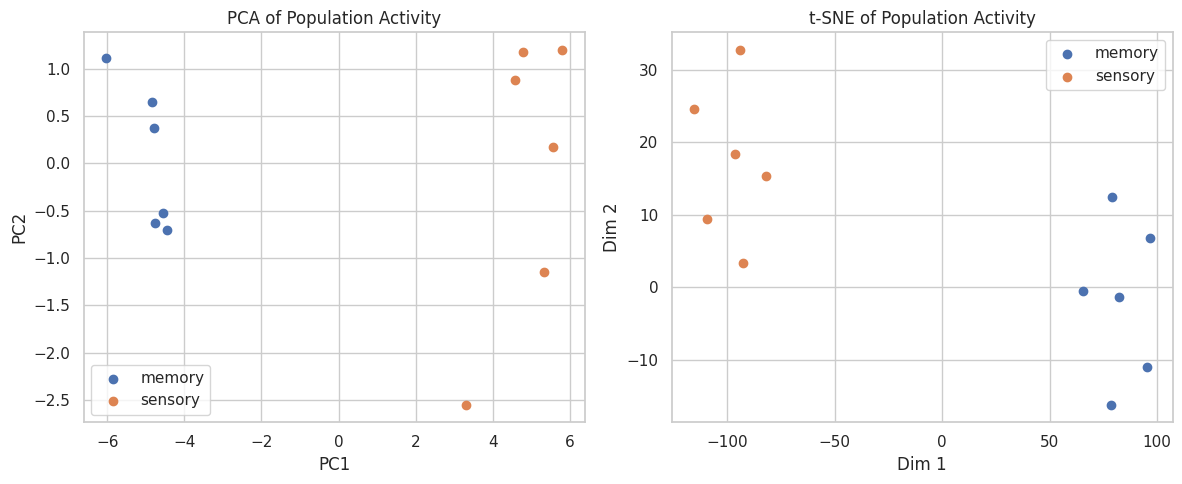

In [7]:
plt.figure(figsize=(12, 5))

# PCA plot
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label)
plt.title('PCA of Population Activity')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# t-SNE plot
plt.subplot(1, 2, 2)
for label in np.unique(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label)
plt.title('t-SNE of Population Activity')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend()

plt.tight_layout()
plt.show()
